In [1]:
### check image resize cifar 10
#https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

### Torch Tutorial Cifar-10

#### Import functions

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

In [3]:
torch.set_default_device('cpu') 

In [4]:
device = torch.device('cuda:0')

#### Prepared DataSet

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root="./../data/", train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root="./../data/", train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


#### Prepare Model

In [6]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, bits):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.hash1 = nn.Linear(120, bits)
        self.sigmoid = nn.Sigmoid()
        self.fc2 = nn.Linear(bits, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.hash1(x)
        hash_= self.sigmoid(x);
        x = self.fc2(x)
        return x, hash_

HASH_SIZE = 64
net = Net( HASH_SIZE )
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (hash1): Linear(in_features=120, out_features=64, bias=True)
  (sigmoid): Sigmoid()
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)

#### Train Parameters

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
iterations = 15

In [8]:
for epoch in range( iterations ):  # loop over the dataset multiple times

    running_loss = 0.0
    total = 0
    correct = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs, hash_ = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 0:
            print(i + 1, " ", end="")
            
        total += labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()

    print(f'[{epoch + 1}] loss: {running_loss} accurancy: {100 * correct // total} %')

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


1  101  201  301  401  501  601  701  [1] loss: 1786.3257319927216 accurancy: 13 %
1  101  201  301  401  501  601  701  [2] loss: 1610.9115617275238 accurancy: 24 %
1  101  201  301  401  501  601  701  [3] loss: 1419.0829795598984 accurancy: 33 %
1  101  201  301  401  501  601  701  [4] loss: 1286.7347688674927 accurancy: 39 %
1  101  201  301  401  501  601  701  [5] loss: 1208.2587403059006 accurancy: 43 %
1  101  201  301  401  501  601  701  [6] loss: 1152.2000560760498 accurancy: 47 %
1  101  201  301  401  501  601  701  [7] loss: 1103.0251423716545 accurancy: 49 %
1  101  201  301  401  501  601  701  [8] loss: 1062.691123366356 accurancy: 51 %
1  101  201  301  401  501  601  701  [9] loss: 1029.7143520116806 accurancy: 52 %
1  101  201  301  401  501  601  701  [10] loss: 1000.5785574913025 accurancy: 54 %
1  101  201  301  401  501  601  701  [11] loss: 972.4539111852646 accurancy: 55 %
1  101  201  301  401  501  601  701  [12] loss: 946.5120226740837 accurancy: 56 %
1  1

#### Save Model

In [9]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

#### Load Model

In [10]:
net = Net( HASH_SIZE ).to(device)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

#### Check visually

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

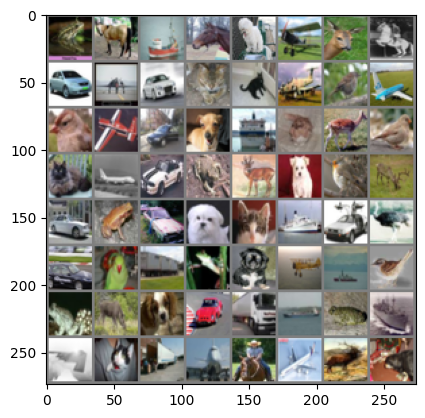

frog  horse ship  horse dog   plane frog  truck car   ship  car   cat   bird  truck deer  plane dog   ship  car   dog   ship  dog   plane bird  truck plane car   dog   horse dog   bird  deer  car   frog  car   dog   cat   ship  truck plane car   deer  truck dog   dog   horse ship  bird  deer  deer  dog   car   truck ship  frog  ship  plane dog   truck ship  horse plane horse deer 
tensor([1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1.,
        0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0.,
        1., 0., 1., 0., 0., 1., 1., 0., 1., 0.], device='cuda:0',
       grad_fn=<SelectBackward0>)


In [12]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

outputs, hashes = net(images.to(device))
_, predicted = torch.max(outputs, 1)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[predicted[j]]:5s}' for j in range(predicted.shape[0])))
print(torch.round(hashes)[0])

#### Check Accurancy on test set

In [13]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs, _ = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 59 %


In [14]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs, _ = net(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 61.1 %
Accuracy for class: car   is 78.2 %
Accuracy for class: bird  is 38.3 %
Accuracy for class: cat   is 25.8 %
Accuracy for class: deer  is 46.5 %
Accuracy for class: dog   is 51.1 %
Accuracy for class: frog  is 71.0 %
Accuracy for class: horse is 71.8 %
Accuracy for class: ship  is 76.0 %
Accuracy for class: truck is 71.6 %


### CustomDataSet ( ImageNet )

In [15]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

In [16]:
IMAGENET_PATH = "../data/Imagenet32_train/"

In [17]:
import os
import _pickle as cPickle

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = cPickle.load(fo)
    return dict

def load_databatch(data_folder, idx, img_size=32):
    data_file = os.path.join(data_folder, 'train_data_batch_')

    dict_ = unpickle(data_file + str(idx))

    images = dict_['data']
    labels = dict_['labels']

    ## images_without_mean = dict_['mean']   ??? check is there are better results or not

    return images, labels

In [18]:
images2, labels2 = load_databatch(IMAGENET_PATH, 1)

In [19]:
print( type(images2) )
print( type(labels2) )

<class 'numpy.ndarray'>
<class 'list'>


In [20]:
images2 = images2.astype(np.float32).reshape(128116,3,32,32)

In [21]:
dataset = CustomDataset(torch.from_numpy(images2), torch.Tensor(labels2) )

In [22]:
ImageNetLoader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

In [23]:
correct = 0
total = 0

with torch.no_grad():
    for data in ImageNetLoader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs, _ = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 0 %


### Concat two models

In [24]:
class Net2(nn.Module):
    def __init__(self, bits):
        super().__init__()
        self.fc1 = nn.Linear(2048, 256)
        self.hash1 = nn.Linear(256, bits)
        self.sigmoid = nn.Sigmoid()
        self.fc2 = nn.Linear(bits, 10)

    def forward(self, x):
        x = x.to(torch.float32)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.hash1(x)
        hash_= self.sigmoid(x);
        x = self.fc2(x)
        return x, hash_

HASH_SIZE = 64
net2 = Net2( HASH_SIZE )
net2.to(device)

Net2(
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (hash1): Linear(in_features=256, out_features=64, bias=True)
  (sigmoid): Sigmoid()
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)

In [26]:
from torchvision import models

resnet50 = models.resnet50(pretrained = True) # weights=ResNet50_Weights.DEFAULT
resnet50 = resnet50.to(device)
resnet50.fc = torch.nn.Identity()

for param in resnet50.parameters():
    param.requires_grad = False

for param in resnet50.fc.parameters():
    param.requires_grad = True
    
for param in resnet50.layer4.parameters():
    param.requires_grad = True

#resnet50

In [27]:
net2 = Net2( HASH_SIZE ).to(device)

In [28]:
model2 = nn.Sequential(resnet50, net2)

In [29]:
#model2

In [30]:
# https://discuss.pytorch.org/t/add-layers-on-pretrained-model/88760
# https://stackoverflow.com/questions/53901603/how-to-transfer-weight-of-own-model-to-same-network-but-different-number-of-clas
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
# https://discuss.pytorch.org/t/copying-weights-from-one-net-to-another/1492
# https://github.com/flyingpot/pytorch_deephash/blob/master/net.py

#https://www.kaggle.com/code/max237/resnet50-transfer-learning-in-pytorch
#https://datagen.tech/guides/computer-vision/resnet-50/#
#https://medium.com/@bravinwasike18/building-a-deep-learning-model-with-keras-and-resnet-50-9dd6f4eb3351
#https://blog.roboflow.com/how-to-use-resnet-50/
#https://pytorch.org/hub/nvidia_deeplearningexamples_resnet50/

In [31]:
criterion2 = nn.CrossEntropyLoss()
#optimizer2 = optim.AdamW(model2.parameters(), lr=0.000025, weight_decay=50)
optimizer2 = optim.SGD(model2.parameters(), lr=0.001, momentum=0.9)
iterations = 50

In [32]:
for epoch in range( 10 ):  # loop over the dataset multiple times

    running_loss = 0.0
    total = 0
    correct = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer2.zero_grad()

        #if epoch > 1:
        #    for param in model2[0].layer4.parameters():
        #        param.requires_grad = False

        outputs, hash_ = model2(inputs)
        loss = criterion2(outputs, labels)
        loss.backward()
        optimizer2.step()
        running_loss += loss.item()
        if i % 100 == 0:
            print(i + 1, " ", end="")
            
        total += labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()

    print(f'[{epoch + 1}] loss: {running_loss} accurancy: {100 * correct // total} %')

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


1  101  201  301  401  501  601  701  

/usr/local/lib/python3.10/dist-packages/torch/utils/_device.py:78: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return func(*args, **kwargs)


[1] loss: 1206.6467047333717 accurancy: 46 %
1  101  201  301  401  501  601  701  [2] loss: 730.0923795104027 accurancy: 67 %
1  101  201  301  401  501  601  701  [3] loss: 569.7966421246529 accurancy: 74 %
1  101  201  301  401  501  601  701  [4] loss: 463.5549733042717 accurancy: 79 %
1  101  201  301  401  501  601  701  [5] loss: 369.35124619305134 accurancy: 83 %
1  101  201  301  401  501  601  701  [6] loss: 295.4030172228813 accurancy: 86 %
1  101  201  301  401  501  601  701  [7] loss: 237.66570661962032 accurancy: 89 %
1  101  201  301  401  501  601  701  [8] loss: 197.09158531576395 accurancy: 91 %
1  101  201  301  401  501  601  701  [9] loss: 172.95380219817162 accurancy: 92 %
1  101  201  301  401  501  601  701  [10] loss: 144.94819086417556 accurancy: 93 %


### Save model

In [34]:
PATH = './mainModel.pth'
#PATH = './modelResnetAndCifar.pth' # 45 jeden optimizer, pozniej 2-gi optimizer
#PATH = './modelResnetAndCifar5.pth' # jeden optimizer
torch.save(model2.state_dict(), PATH)

In [35]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs, _ = model2(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 78.1 %
Accuracy for class: car   is 74.8 %
Accuracy for class: bird  is 60.4 %
Accuracy for class: cat   is 50.1 %
Accuracy for class: deer  is 64.1 %
Accuracy for class: dog   is 61.1 %
Accuracy for class: frog  is 74.8 %
Accuracy for class: horse is 75.9 %
Accuracy for class: ship  is 79.1 %
Accuracy for class: truck is 78.4 %


In [38]:
correct = 0
total = 0

total_labels = None
total_predictions = None

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs, _ = model2(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 69 %


#### Another try 

In [39]:
resnet50_2 = models.resnet50(pretrained = True)
resnet50_2 = resnet50_2.to(device)

for param in resnet50_2.parameters():
    param.requires_grad = False

resnet50_2.fc = nn.Sequential(nn.Linear(2048, 256),
                         nn.ReLU(),
                         nn.Linear(256, 1),
                         nn.Sigmoid())

In [40]:
for param in resnet50_2.fc.parameters():
    param.requires_grad = True
    
# Unfreeze the last few layers of the model

for param in resnet50_2.layer4.parameters():
    param.requires_grad = True

In [41]:
# https://www.kaggle.com/code/kmldas/cifar10-resnet-90-accuracy-less-than-5-min
# https://www.kaggle.com/code/max237/resnet50-transfer-learning-in-pytorch

### mAP - evaluate

In [42]:
#https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/object_detection/metrics/mean_avg_precision.py
#https://www.youtube.com/watch?v=FppOzcDvaDI
#https://lightning.ai/docs/torchmetrics/stable/detection/mean_average_precision.html
#https://www.v7labs.com/blog/mean-average-precision
#https://yanfengliux.medium.com/the-confusing-metrics-of-ap-and-map-for-object-detection-3113ba0386ef
#https://github.com/flyingpot/pytorch_deephash/blob/master/evaluate.py

#https://medium.com/voice-tech-global/machine-learning-confidence-scores-all-you-need-to-know-as-a-conversation-designer-8babd39caae7

In [43]:
# https://www.youtube.com/watch?v=FppOzcDvaDI
# https://pytorch.org/torcheval/stable/generated/torcheval.metrics.functional.binary_auprc.html
# https://pytorch.org/torcheval/main/generated/torcheval.metrics.functional.multiclass_auprc.html#torcheval.metrics.functional.multiclass_auprc

In [44]:
# praca magisterska
# 1. spor recall - precision
# 2. mAP co to jest 
# 3. PyTorch zapewnia metryki
# 4. dHash, pHash itp.
# 5. trzeci wlasny sens, przyklad w zyciu codziennym czy to ma sens ?

In [45]:
#!pip install torcheval

In [46]:
correct = 0
total = 0

testloader2 = torch.utils.data.DataLoader(testset, batch_size=len(testset), shuffle=False)

with torch.no_grad():
    for data in testloader2:
        images, labels = data[0].to(device), data[1].to(device)
        outputs, _ = model2(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 71 %


In [47]:
print(outputs.shape)
print(labels.shape)
print(outputs[0])

torch.Size([10000, 10])
torch.Size([10000])
tensor([-6.0961, -1.5731, -2.0612, 15.8006, -3.6953,  8.7083, -1.1969,  0.5701,
        -2.9815, -2.2048], device='cuda:0')


In [48]:
from torcheval.metrics.functional import multiclass_auprc

In [49]:
print( "mAP value equals to: ", multiclass_auprc(outputs, labels))

mAP value equals to:  tensor(0.7379, device='cuda:0')
